In [ ]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from torchvision.datasets import VOCDetection
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_voc_data():
    root_dir = "/content/VOCdevkit"

    try:
        dataset = VOCDetection(
            root=root_dir,
            year="2012",
            image_set="trainval",
            transform=T.ToTensor(),
            download=True
        )
        print(f"Dataset loaded successfully! Total samples: {len(dataset)}")
    except RuntimeError as e:
        print(f"Error loading dataset: {e}")
    return dataset

load_voc_data()

100%|██████████| 2.00G/2.00G [01:36<00:00, 20.8MB/s]


Extracting /content/VOCdevkit/VOCtrainval_11-May-2012.tar to /content/VOCdevkit
Dataset loaded successfully! Total samples: 11540


Dataset VOCDetection
    Number of datapoints: 11540
    Root location: /content/VOCdevkit
    StandardTransform
Transform: ToTensor()

In [ ]:
import os
from torchvision.datasets import VOCDetection
import torchvision.transforms as T
import numpy as np

def load_voc_data():


    # Path to the VOC dataset
    root_dir = "/content/VOCdevkit"
    dataset = VOCDetection(
        root=root_dir,
        year="2012",
        image_set="trainval",
        transform=T.ToTensor()
    )

    # Containers for images and bounding boxes
    images = []
    bboxes = []

    # Iterate through the dataset
    for img, target in dataset:
        try:
            # Extract bounding box information
            bbox = target["annotation"]["object"][0]["bndbox"]
            xmin = int(bbox["xmin"])
            ymin = int(bbox["ymin"])
            xmax = int(bbox["xmax"])
            ymax = int(bbox["ymax"])

            # Convert tensor image to NumPy array
            images.append(img.permute(1, 2, 0).numpy())  # HWC format
            bboxes.append([xmin, ymin, xmax, ymax])  # Bounding box coordinates
        except (KeyError, IndexError):
            # Skip samples without valid bounding boxes
            print("Skipping invalid sample...")
            continue

    return images, bboxes




In [ ]:
from skimage.feature import hog


#### SECOND ITER #####
def extract_features(image):
    # Resize the image to a fixed size for consistency
    fixed_size = (128, 128)  # Resize all images to 128x128
    resized_image = cv2.resize(image, fixed_size)

    # Convert to grayscale (HOG works on grayscale)
    gray = cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)

    # Extract pixel intensity features
    pixel_features = gray.flatten()  # Flatten to 1D array

    # Extract HOG features
    hog_features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(16, 16),  # Set pixels per cell
        cells_per_block=(2, 2),   # Set cells per block
        block_norm="L2-Hys",
        visualize=False,
        feature_vector=True
    )

    # Combine all features
    combined_features = np.concatenate([pixel_features, hog_features])
    return combined_features

In [ ]:
def extract_features_v0(image):
    """
    Extract features from an image for machine learning training.
    """
    resized = cv2.resize(image, (32, 32))  # Resize to 32x32
    return resized.flatten()  # Flatten into a 1D array

In [ ]:
def prepare_training_data(images, bboxes):
    features = np.array([extract_features(img) for img in images])  # Extract features
    targets = np.array(bboxes)  # Bounding box targets
    return train_test_split(features, targets, test_size=0.2, random_state=42)

In [ ]:
import joblib
def train_model_random_forest(X_train, y_train):
    # Use a Random Forest Regressor for bounding box prediction
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    return model


In [ ]:
from xgboost import XGBRegressor
def train_model_xgb(X_train, y_train):
    model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_train, y_train)
    return model

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.2f}")
    return y_pred

In [ ]:
def visualize_prediction(model, image, bbox):
    predicted_bbox = model.predict([extract_features(image)])[0]

    # Visualize the original and predicted bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap="gray")

    # Original bounding box
    rect_true = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
        linewidth=2, edgecolor="g", facecolor="none", label="True Bounding Box"
    )
    ax.add_patch(rect_true)

    # Predicted bounding box
    rect_pred = patches.Rectangle(
        (predicted_bbox[0], predicted_bbox[1]),
        predicted_bbox[2] - predicted_bbox[0],
        predicted_bbox[3] - predicted_bbox[1],
        linewidth=2, edgecolor="r", facecolor="none", label="Predicted Bounding Box"
    )
    ax.add_patch(rect_pred)

    plt.legend()
    plt.title("XGBoost : Bounding Box Prediction")

    # Save the figure if save_path is provided
    if save_path:
        plt.savefig("./random.jpg", dpi=300, bbox_inches="tight")
        print(f"Visualization saved to {save_path}")
    plt.show()

In [ ]:
print("Loading Pascal VOC data...")
images, bboxes = load_voc_data()

print("Preparing training data...")
X_train, X_test, y_train, y_test = prepare_training_data(images, bboxes)

Loading Pascal VOC data...
Preparing training data...


In [ ]:
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 9232, Testing samples: 2308


In [ ]:
print("Training the model...")
model = train_model_xgb(X_train, y_train)


print("Evaluating the model...")
y_pred = evaluate_model(model, X_test, y_test)

Training the model...
Evaluating the model...
Mean Squared Error: 9120.36


In [ ]:
import joblib

# Specify the file path to save the model
model_path = "/content/xgb.pkl"

# Save the model
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

Model saved to /content/xgb.pkl


In [ ]:
print("Visualizing a prediction...")
# save image to content

from PIL import Image
import numpy as np

# Save the 6432nd image
def save_image(image, save_path):
    """
    Save a NumPy array image to a file.

    Args:
    - image: The input image (NumPy array).
    - save_path: Path to save the image (e.g., "image.jpg").
    """
    if isinstance(image, np.ndarray):
        # Convert the NumPy array to an image and ensure it's scaled to [0, 255]
        img = Image.fromarray((image * 255).astype(np.uint8))  # For normalized images
        img.save(save_path)
        print(f"Image saved to {save_path}")
    else:
        raise ValueError("Input image must be a NumPy array.")



Visualizing a prediction...


Model loaded successfully!
Visualization saved to imgrandom.jpg


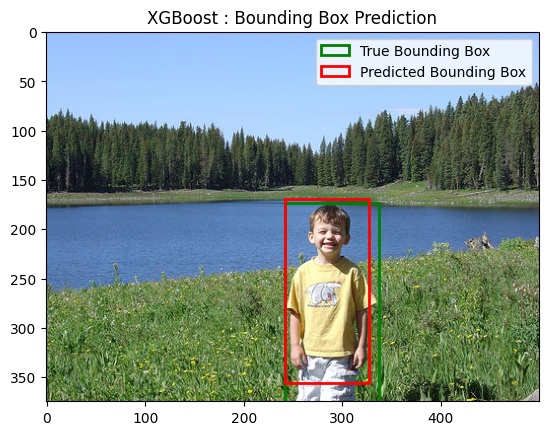

Image saved to imgrandom.jpg


In [ ]:
import joblib

#print("Loading Pascal VOC data...")
#images, bboxes = load_voc_data()
model_path = "/content/xgb.pkl"
model2 = joblib.load(model_path)
print("Model loaded successfully!")

visualize_prediction(model2, images[691], bboxes[691])
save_path = "imgrandom.jpg"
save_image(images[553], save_path)


In [ ]:
import joblib

model_path = "/content/random_forest.pkl"
model2 = joblib.load(model_path)
print("Model loaded successfully!")

visualize_prediction(model2, images[6432], bboxes[6432])


ValueError: EOF: reading array data, expected 262144 bytes got 95824